<a href="https://colab.research.google.com/github/Gongsoo/Python3/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#drive mounting
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#data load
import pandas as pd

df_cov = pd.read_excel('/content/gdrive/My Drive/data_tx.xlsx')
df_cov.describe()

,일일 확진자,누적 확진자,감염재생산지수
count,252.000000,2.520000e+02,252.000000
mean,4056.888889,3.547426e+05,1.177989
std,3460.272018,3.384328e+05,0.469323
min,1.000000,3.000000e+00,0.729037
25%,972.000000,3.575900e+04,0.925234
50%,3605.500000,2.307350e+05,1.085735
75%,6302.000000,6.679102e+05,1.195910
max,21771.000000,1.022336e+06,3.560410


# 새 섹션

In [ ]:
#data making function
import numpy as np

def monitor_day(x, y, day_size):
    x_list = []
    y_list = []
    for i in range(day_size,len(x)):
        x_list.append(np.array(x.iloc[i-day_size:i]))
        y_list.append(np.array(y.iloc[i]))
    return np.array(x_list), np.array(y_list)

In [ ]:
#data making
SIZE = 200
train = df_cov[:SIZE]
test = df_cov[SIZE:]

x_cols = ['일일 확진자', '누적 확진자', '감염재생산지수']
y_cols = ['일일 확진자']

x_data = train[x_cols]
y_data = train[y_cols]

x_data, y_data = monitor_day(x_data, y_data, 7)

In [ ]:
#data split
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.2)

x_train.shape, x_valid.shape
y_train.shape, y_valid.shape

((154, 1), (39, 1))

In [ ]:
#lstm model
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=32)
history = model.fit(x_train, y_train, epochs=200, batch_size=2,validation_data=(x_valid, y_valid), callbacks=early_stop)

Epoch 1/200
77/77 [==============================] - 4s 8ms/step - loss: 888756544.0000 - val_loss: 666740608.0000
Epoch 2/200
77/77 [==============================] - 0s 5ms/step - loss: 899992256.0000 - val_loss: 1047336704.0000
Epoch 3/200
77/77 [==============================] - 0s 5ms/step - loss: 897640640.0000 - val_loss: 229852032.0000
Epoch 4/200
77/77 [==============================] - 1s 10ms/step - loss: 119746760.0000 - val_loss: 93122912.0000
Epoch 5/200
77/77 [==============================] - 0s 5ms/step - loss: 101663448.0000 - val_loss: 8956486.0000
Epoch 6/200
77/77 [==============================] - 0s 6ms/step - loss: 13707793.0000 - val_loss: 9341262.0000
Epoch 7/200
77/77 [==============================] - 0s 5ms/step - loss: 14794496.0000 - val_loss: 18274068.0000
Epoch 8/200
77/77 [==============================] - 0s 5ms/step - loss: 37811160.0000 - val_loss: 10522609.0000
Epoch 9/200
77/77 [==============================] - 1s 7ms/step - loss: 54523144.0000 -

In [ ]:
#model save& model testing
from keras.models import load_model
model.save('/content/gdrive/My Drive/lstm_tx.h5')
x_test = test[x_cols]
y_test = test[y_cols]
model=load_model('/content/gdrive/My Drive/lstm_tx.h5')
x_test, y_test = monitor_day(x_test, y_test, 7)
x_test.shape, y_test.shape

pred = model.predict(x_test)

2/2 [==============================] - 0s 8ms/step


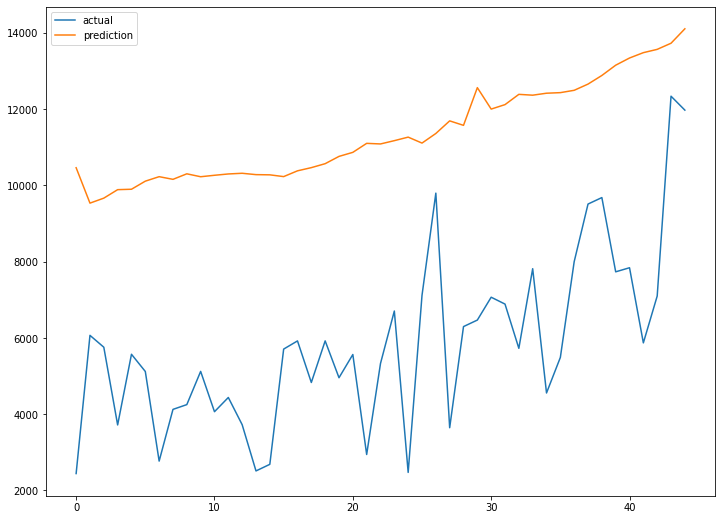

In [ ]:
#test modeling plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
#predict function
def predict_days(x,y,z) :
  temp_arr = np.array([x])
  temp_acc = np.array([y+x])
  temp_arr = np.append(temp_arr,temp_acc)
  temp_rt = np.array([z])
  temp_arr= np.append(temp_arr,temp_rt)
  return temp_arr

In [ ]:
#predict
x_predict=np.zeros((30))
x_temp= df_cov[245:]
x_temp = x_temp[x_cols]
x_temp = np.array(x_temp)
x_temp = x_temp.reshape(1,7,3)
for i in range(30) :
  temp_predict = model.predict(x_temp.reshape(1,7,3))
  new_data = predict_days(temp_predict,x_temp[0,6,1],x_temp[0,6,2])
  x_predict[i]= temp_predict
  x_temp = np.append(x_temp, new_data.reshape(1,1,3), axis=1)
  x_temp = np.delete(x_temp,0,axis=1)


1/1 [==============================] - 0s 15ms/step


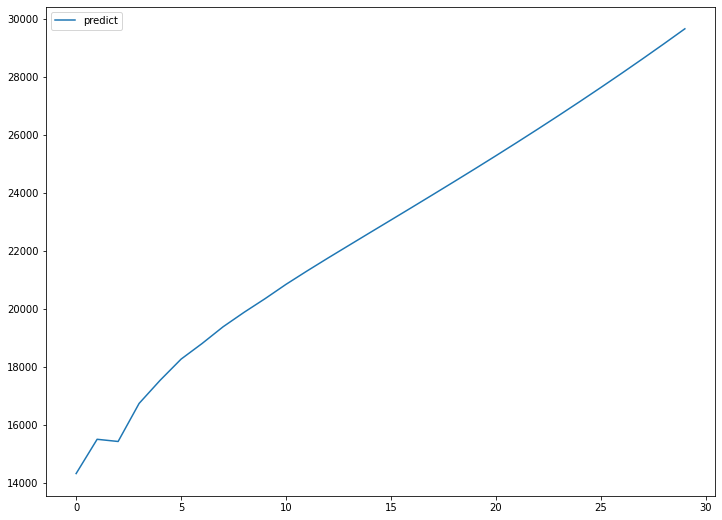

In [ ]:
#predict plot
plt.figure(figsize=(12,9))
plt.plot(x_predict, label='predict')
plt.legend()
plt.show
plt.savefig('/content/gdrive/My Drive/test_tx.png')